In [64]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
df = pd.read_pickle('../data/arxiv_metadata_2022.pkl')
# df['update_date'] = pd.to_datetime(df['update_date'])
df['date'] = pd.to_datetime(df['versions'].apply(lambda x: x[0]['created'])) # converting to datetime takes a while
df = df.drop(columns=['versions', 'update_date'])
df = df.drop_duplicates(subset=['title', 'authors'], keep='first') # replicated submissions
# df['num_versions'] = df['versions'].apply(len)
df.shape

[{'version': 'v1', 'created': 'Fri, 13 Apr 2007 15:53:44 GMT'},
 {'version': 'v2', 'created': 'Sun, 29 Apr 2007 15:40:10 GMT'},
 {'version': 'v3', 'created': 'Mon, 21 Apr 2008 17:25:06 GMT'}]

In [66]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

(array([4.7000e+01, 8.5000e+01, 2.8300e+02, 4.9400e+02, 7.2700e+02,
        2.0920e+03, 7.3650e+03, 1.3062e+04, 4.4264e+04, 9.0197e+04]),
 array([1993. , 1995.9, 1998.8, 2001.7, 2004.6, 2007.5, 2010.4, 2013.3,
        2016.2, 2019.1, 2022. ]),
 <BarContainer object of 10 artists>)

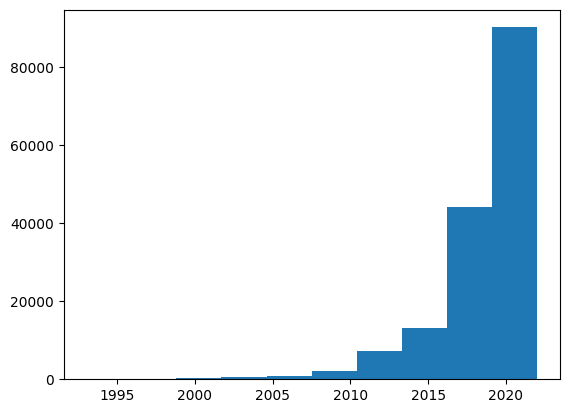

In [65]:
plt.hist(df['year'])

## Data Preparation
We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [6]:


labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


Both baseball and hockey are single tokens. We save the dataset as a jsonl file.

In [7]:
df.to_json("sport2.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [9]:
!openai tools fine_tunes.prepare_data -f sport2.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

In [9]:
!openai api fine_tunes.create -t "sport2_prepared_train.jsonl" -v "sport2_prepared_valid.jsonl" -m ada

Upload progress: 100%|████████████████████| 1.52M/1.52M [00:00<00:00, 1.81Mit/s]
Uploaded file from sport2_prepared_train.jsonl: file-Dxx2xJqyjcwlhfDHpZdmCXlF
Upload progress: 100%|███████████████████████| 388k/388k [00:00<00:00, 507kit/s]
Uploaded file from sport2_prepared_valid.jsonl: file-Mvb8YAeLnGdneSAFcfiVcgcN
Created fine-tune: ft-2zaA7qi0rxJduWQpdvOvmGn3
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2021-07-30 13:15:50] Created fine-tune: ft-2zaA7qi0rxJduWQpdvOvmGn3
[2021-07-30 13:15:52] Fine-tune enqueued. Queue number: 0
[2021-07-30 13:15:56] Fine-tune started
[2021-07-30 13:18:55] Completed epoch 1/4
[2021-07-30 13:20:47] Completed epoch 2/4
[2021-07-30 13:22:40] Completed epoch 3/4
[2021-07-30 13:24:31] Completed epoch 4/4
[2021-07-30 13:26:22] Uploaded model: ada:ft-openai-2021-07-30-12-26-20
[2021-07-30 13:26:27] Uploaded result file: file-6Ki9RqLQwkChGsr9CHcr1ncg
[2021-07-30 13:26:28] Fine-tune succee

The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

## Using the model
We can now call the model to get the predictions.

In [13]:
test = pd.read_json('sport2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball


We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [14]:
ft_model = 'ada:ft-openai-2021-07-30-12-26-20'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']


' hockey'

To get the log probabilities, we can specify logprobs parameter on the completion request

In [15]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7fe114e435c8> JSON: {
  " baseball": -7.6311407,
  " hockey": -0.0006307676
}